<a href="https://colab.research.google.com/github/shirsneh/Computer-Vision/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression With Mini-Batch Gradient Descent

### Preparing the enviorment

In [1]:
!pip3 install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

### Plotting the data

In [3]:
class plot_error_surfaces(object):
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                yhat= 1 / (1 + np.exp(-1*(w2*self.x+b2)))
                Z[count1,count2]=-1*np.mean(self.y*np.log(yhat+1e-16) +(1-self.y)*np.log(1-yhat+1e-16))
                count2 += 1
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()

    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)

    def final_plot(self):
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x[self.y==0], self.y[self.y==0], 'ro', label="training points")
        plt.plot(self.x[self.y==1], self.y[self.y==1]-1, 'o', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')

def PlotStuff(X, Y, model, epoch, leg=True):

    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg == True:
        plt.legend()
    else:
        pass

In [4]:
# Setting the seed will allow us to control randomness and give us reproducibility
torch.manual_seed(0)

### Loading the data

In [5]:
class Data(Dataset):
    def __init__(self):
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)
        self.y = torch.zeros(self.x.shape[0], 1)
        self.y[self.x[:, 0] > 0.2] = 1
        # Set the .len attribute because we need to override the __len__ method
        self.len = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

In [6]:
# Create Data object
data_set = Data()

In [7]:
data_set.x

tensor([[-1.0000e+00],
        [-9.0000e-01],
        [-8.0000e-01],
        [-7.0000e-01],
        [-6.0000e-01],
        [-5.0000e-01],
        [-4.0000e-01],
        [-3.0000e-01],
        [-2.0000e-01],
        [-1.0000e-01],
        [-2.9802e-09],
        [ 1.0000e-01],
        [ 2.0000e-01],
        [ 3.0000e-01],
        [ 4.0000e-01],
        [ 5.0000e-01],
        [ 6.0000e-01],
        [ 7.0000e-01],
        [ 8.0000e-01],
        [ 9.0000e-01]])

In [8]:
data_set.y

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [9]:
len(data_set)

20

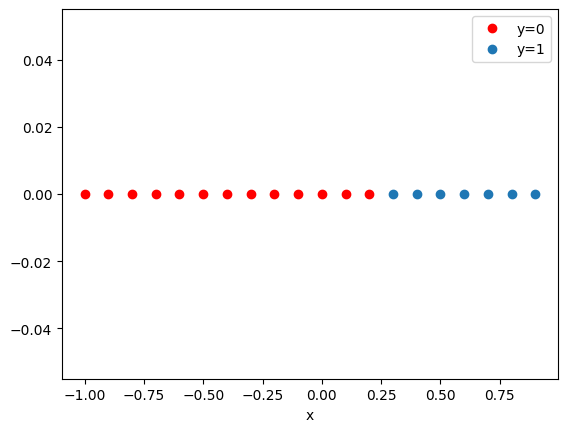

In [10]:
plt.plot(data_set.x[data_set.y==0], data_set.y[data_set.y==0], 'ro', label="y=0")
plt.plot(data_set.x[data_set.y==1], data_set.y[data_set.y==1]-1, 'o', label="y=1")
plt.xlabel('x')
plt.legend()

## Create the Model and Total Loss Function (Cost)

For Logistic Regression typically we would not use PyTorch instead we would use Scikit-Learn as it is easier to use and set up. We are using PyTorch because it is good practice for deep learning. Scikit-Learn is typically used for Machine Learning while PyTorch is used for Deep Learning.

We will create a custom class that defines the architecture of Logistic Regression using PyTorch. Logistic Regression has a single layer where the input is the number of features an X value of the dataset has (dimension of X) and there is a single output. The output of the layer is put into a sigmoid function which is a function between 0 and 1. The larger the output of the layer the closer it is to 1 and the smaller the output is the closer it is to 0. The sigmoid function will allow us to turn this output into a classification problem. If the output value is closer to 1 it is one class if it is closer to 0 it is in another.

Sigmoid Function

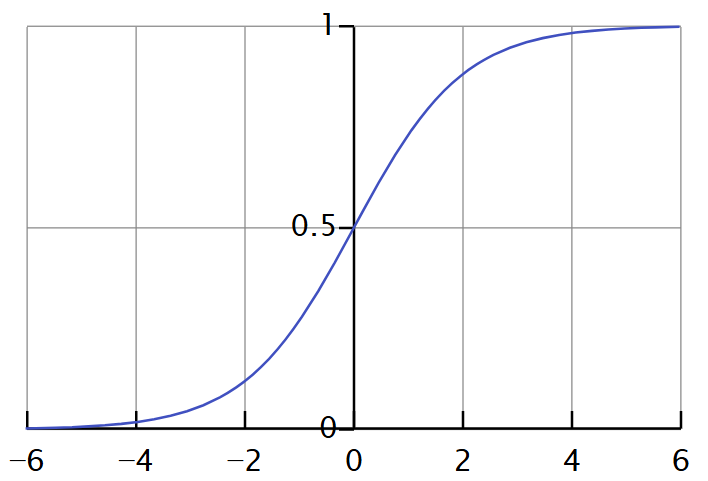

In [11]:
# Create logistic_regression class that inherits nn.Module which is the base class for all neural networks
class logistic_regression(nn.Module):
    def __init__(self, n_inputs):
        super(logistic_regression, self).__init__()
        self.linear = nn.Linear(n_inputs, 1)

    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat

In [12]:
x,y = data_set[0]
len(x)

1

In [13]:
model = logistic_regression(1)

prediction sigma  𝜎
  this uses the forward function defined above

In [14]:
x = torch.tensor([-1.0])

sigma = model(x)
sigma

tensor([0.6327], grad_fn=<SigmoidBackward0>)

prediction using our data

In [15]:
x,y = data_set[2]

sigma = model(x)
sigma

tensor([0.6324], grad_fn=<SigmoidBackward0>)

We can see on the Loss Surface graph, the loss value varying across w and b values with yellow being high loss and dark blue being low loss which is what we want

On the Loss Surface Contour graph we can see a top-down view of the Loss Surface graph

<Figure size 640x480 with 0 Axes>

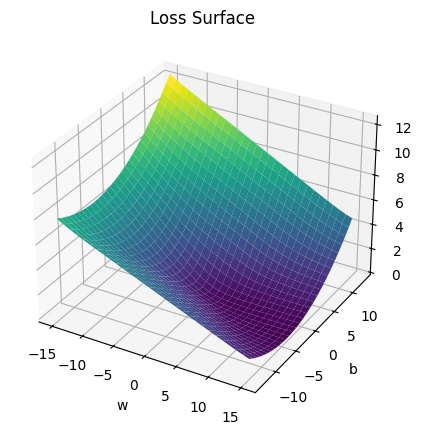

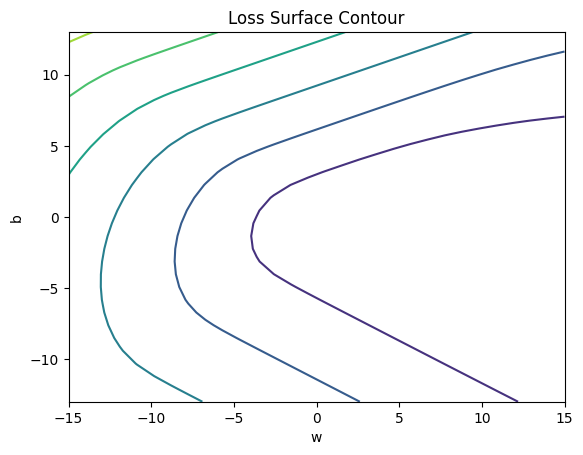

In [16]:
# Create the plot_error_surfaces object

# 15 is the range of w
# 13 is the range of b
# data_set[:][0] are all the X values
# data_set[:][1] are all the Y values

get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1])

We define a criterion using Binary Cross Entropy Loss. This will measure the difference/loss between the prediction and actual value.

In [17]:
criterion = nn.BCELoss()

Make a prediction

In [18]:
sigma = model(x)
sigma

tensor([0.6324], grad_fn=<SigmoidBackward0>)

Calculate the loss

In [19]:
loss = criterion(sigma, y)
loss

tensor(1.0007, grad_fn=<BinaryCrossEntropyBackward0>)

## Setting the Batch Size using a Data Loader

In [20]:
batch_size=10
trainloader = DataLoader(dataset = data_set, batch_size = 10)
dataset_iter = iter(trainloader)
X,y=next(dataset_iter)
X

tensor([[-1.0000],
        [-0.9000],
        [-0.8000],
        [-0.7000],
        [-0.6000],
        [-0.5000],
        [-0.4000],
        [-0.3000],
        [-0.2000],
        [-0.1000]])

### Setting the Learning Rate

We can set the learning rate by setting it as a parameter in the optimizer along with the parameters of the logistic regression model we are training.

In [21]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

## Train the Model via Mini-Batch Gradient Descent

We are going to train the model using various Batch Sizes and Learning Rates.

<Figure size 640x480 with 0 Axes>

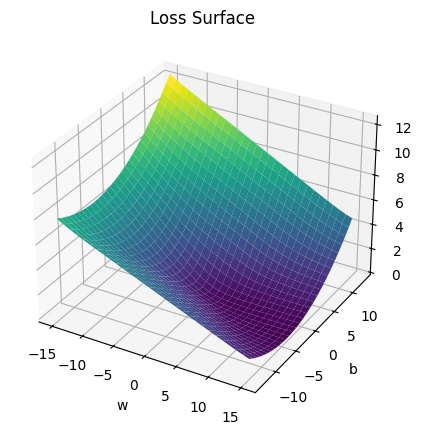

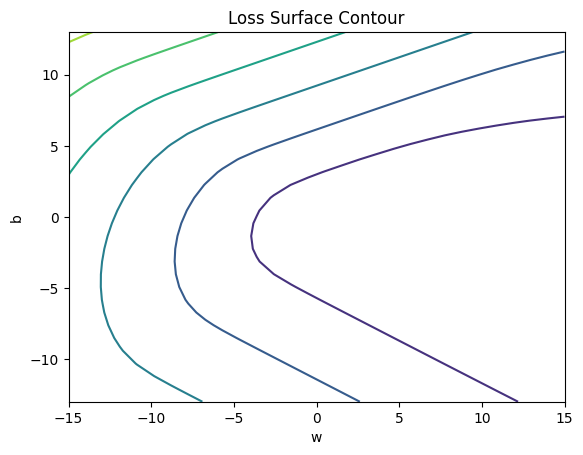

In [22]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

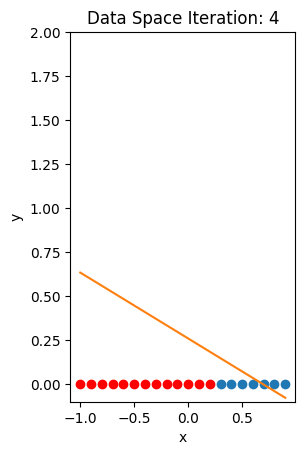

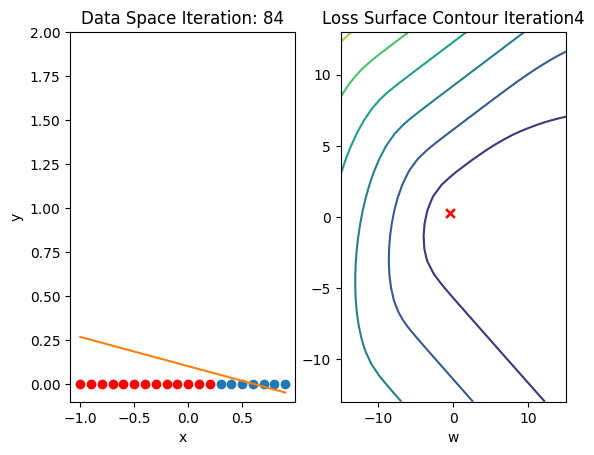

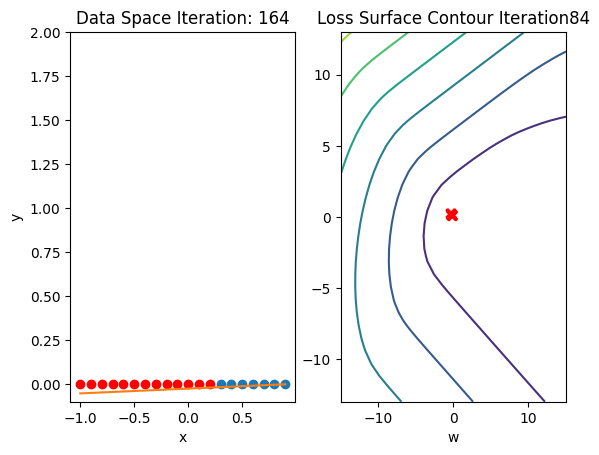

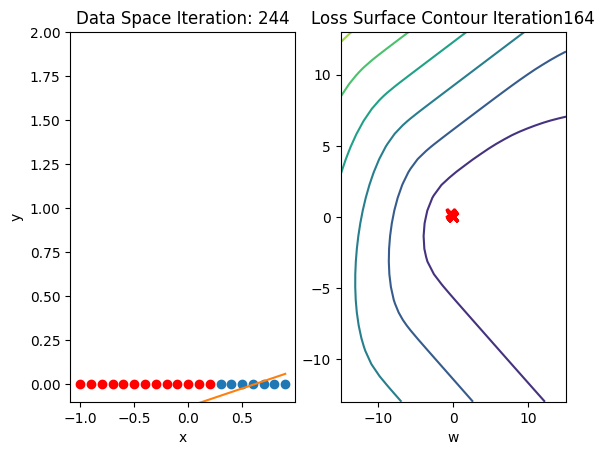

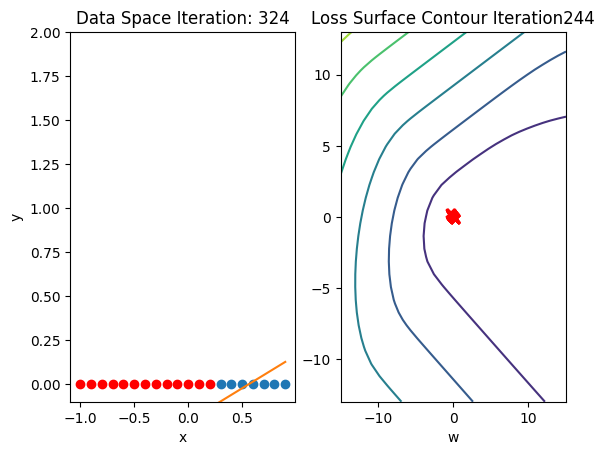

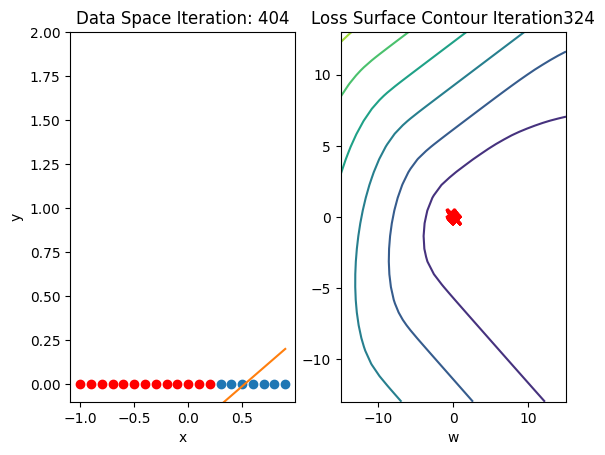

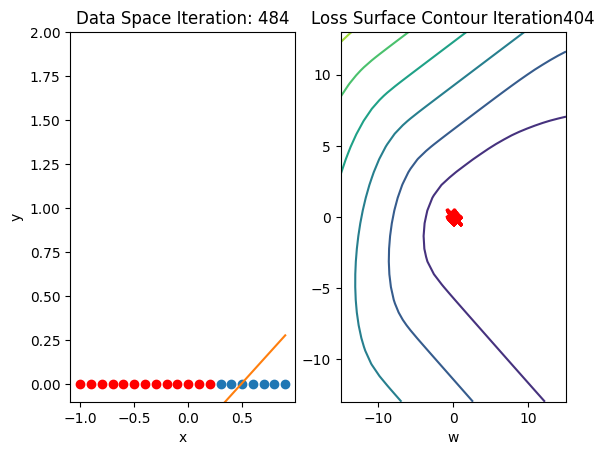

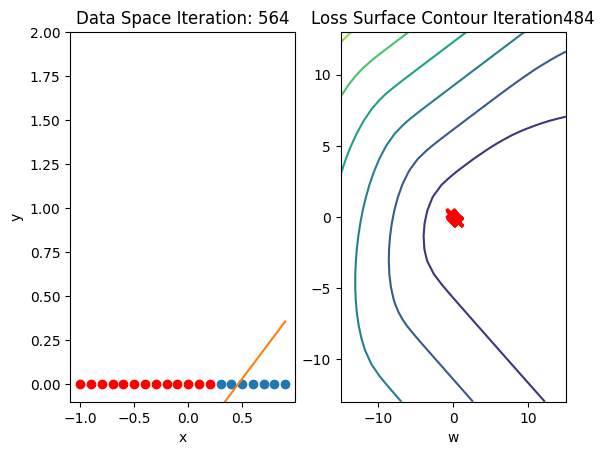

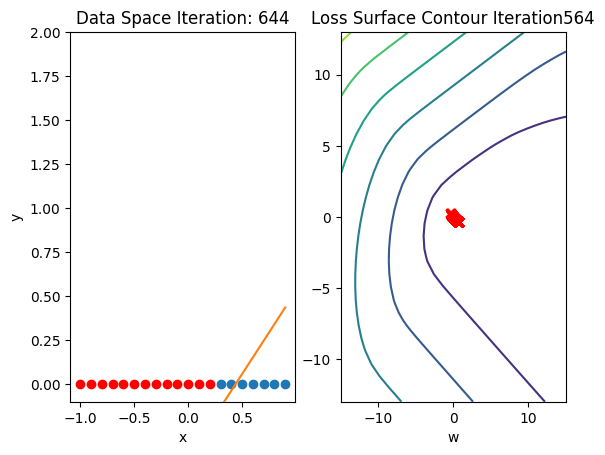

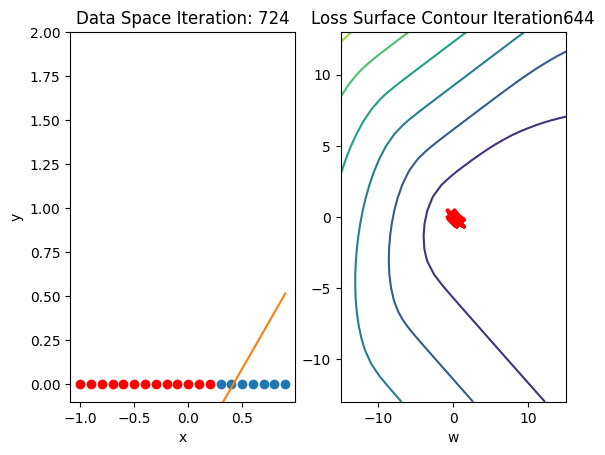

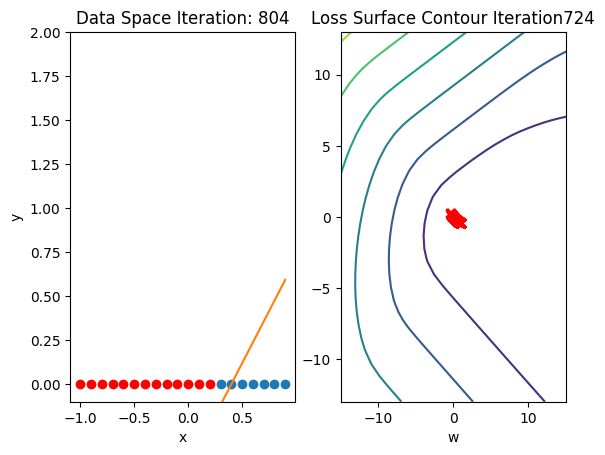

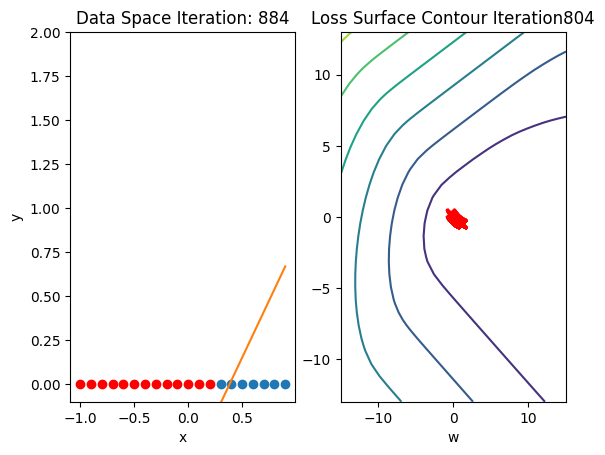

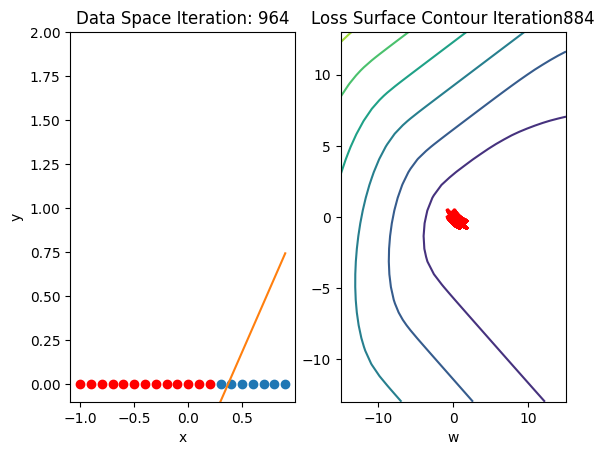

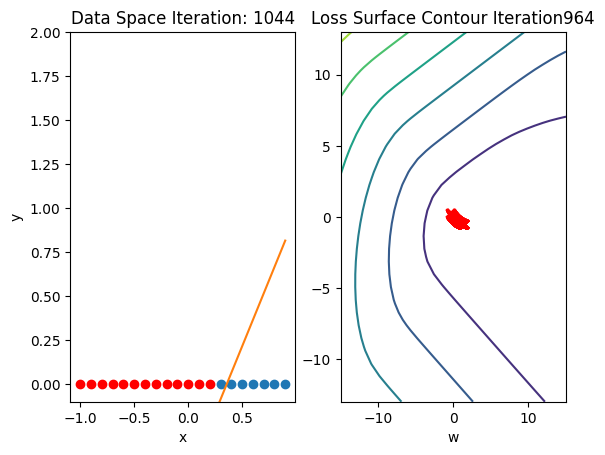

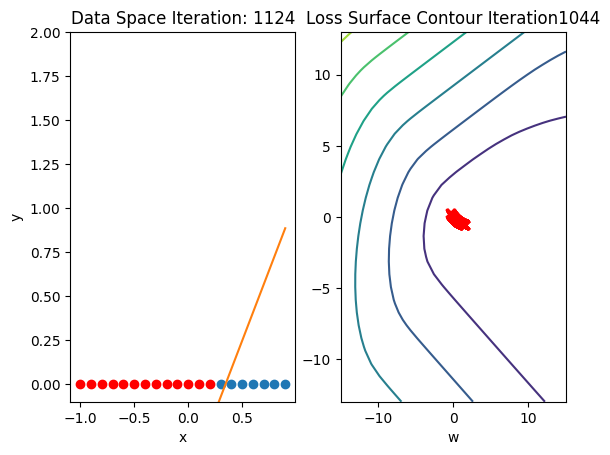

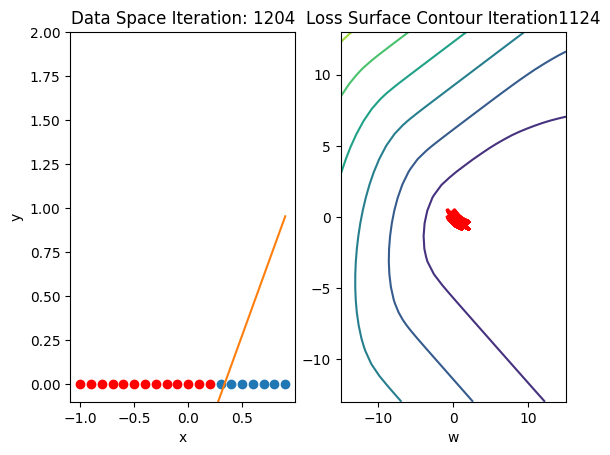

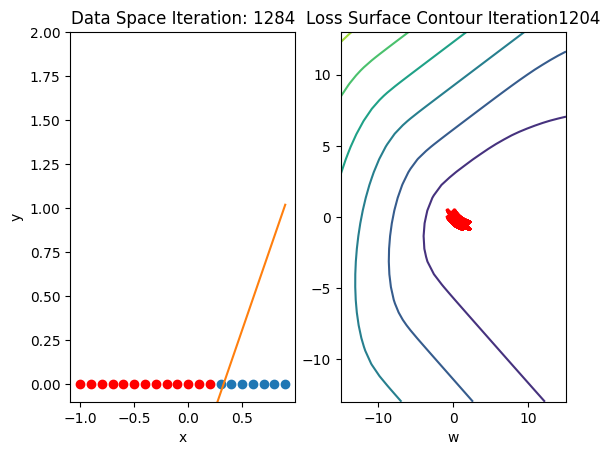

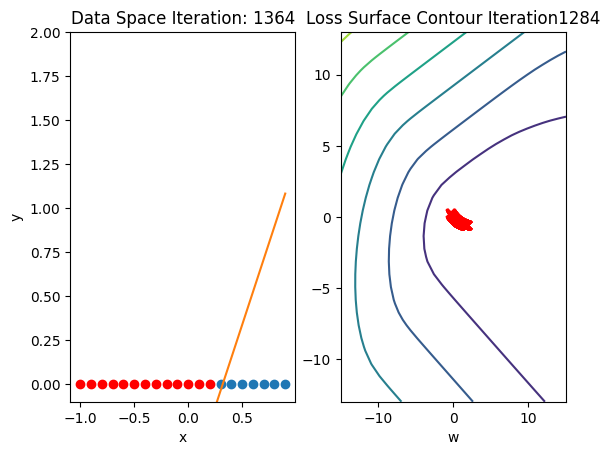

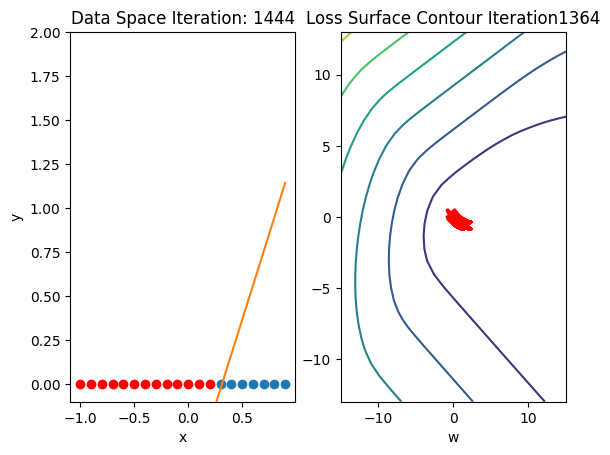

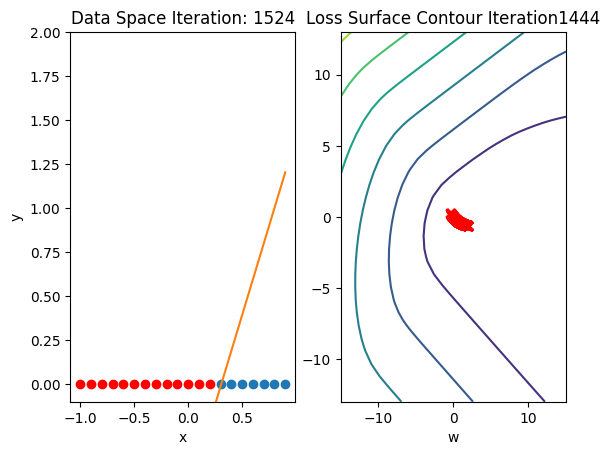

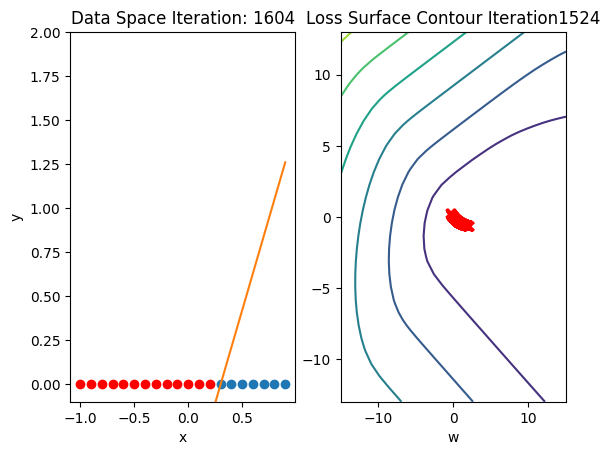

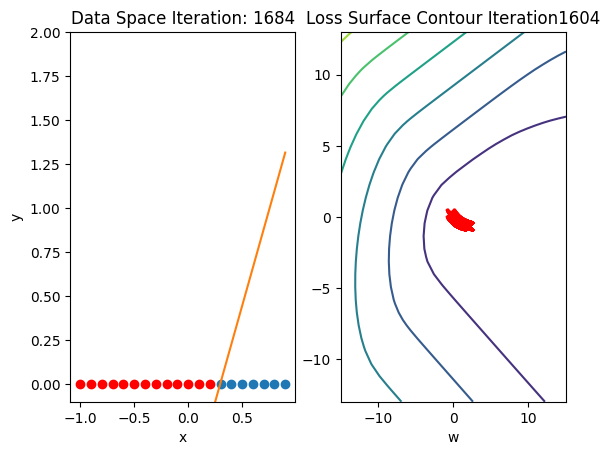

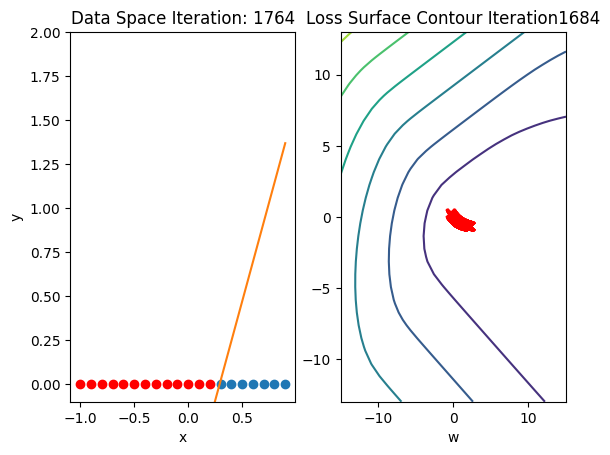

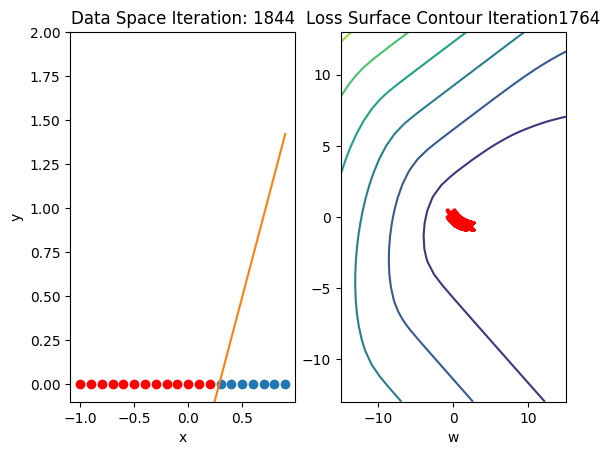

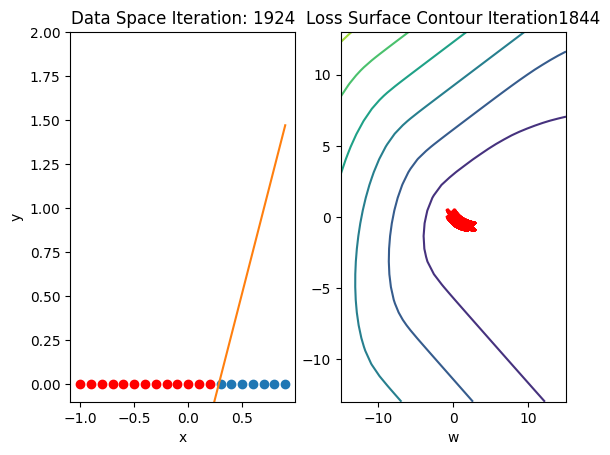

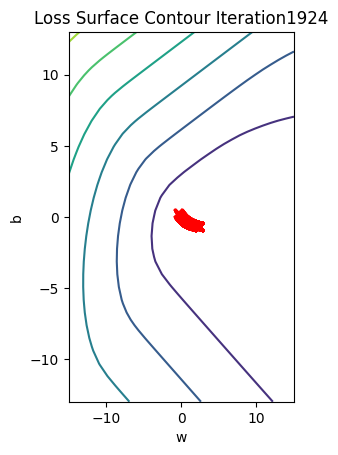

In [23]:
model = logistic_regression(1)
criterion = nn.BCELoss()
trainloader = DataLoader(dataset = data_set, batch_size = 5)
optimizer = torch.optim.SGD(model.parameters(), lr = .01)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs=500
loss_values = []

for epoch in range(epochs):
    for x, y in trainloader:
        yhat = model(x)
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        loss_values.append(loss)
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
       get_surface.plot_ps()

We can see the final values of the weight and bias. This weight and bias correspond to the orange line in the Data Space graph and the final spot of the X in the Loss Surface Contour graph.

In [24]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([2.4503]) b =  tensor(-0.6884)


Now we can get the accuracy of the training data

In [25]:
yhat = model(data_set.x)
yhat = torch.round(yhat)
correct = 0
for prediction, actual in zip(yhat, data_set.y):
    if (prediction == actual):
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


Finally, we plot the Cost vs Iteration graph, although it is erratic it is downward sloping.

Text(0, 0.5, 'Cost')

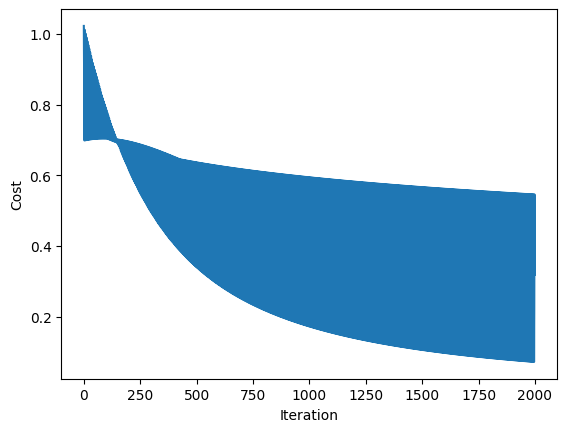

In [26]:
LOSS_BGD1=[]
for i in loss_values:
    LOSS_BGD1.append(i.item())

plt.plot(LOSS_BGD1)
plt.xlabel("Iteration")
plt.ylabel("Cost")

## Stochastic Gradient Descent

In this case, we will set the batch size of the data loder to 1 so that the gradient descent will be performed for each example this is referred to as Stochastic Gradient Descent. The number of epochs is set to 100.

Notice that in this example the batch size is decreased from 5 to 1 so there would be more iterations. Due to this, we can reduce the number of iterations by decreasing the number of epochs. Due to the reduced batch size, we are optimizing more frequently so we don't need as many epochs.

First, we must recreate the get_surface object again so that for each example we get a Loss Surface for that model only.

<Figure size 640x480 with 0 Axes>

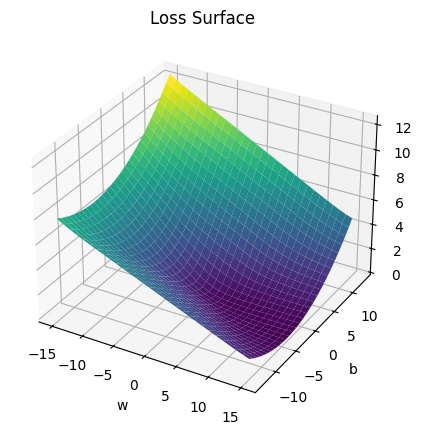

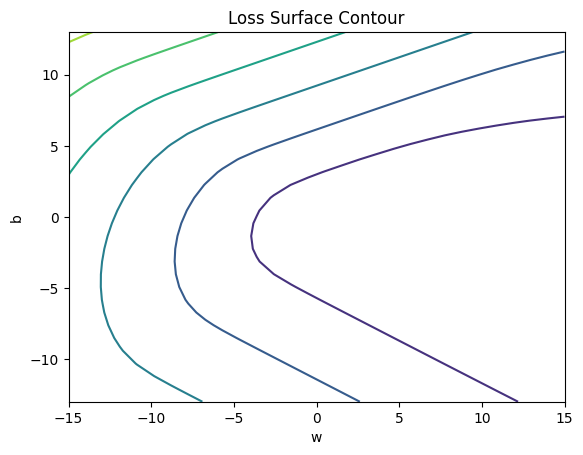

In [27]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

Train the model

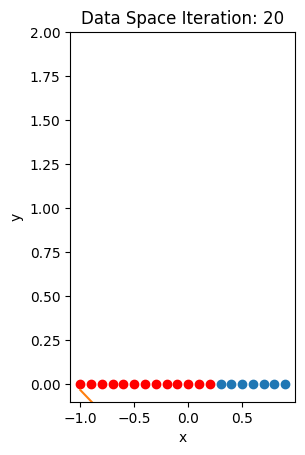

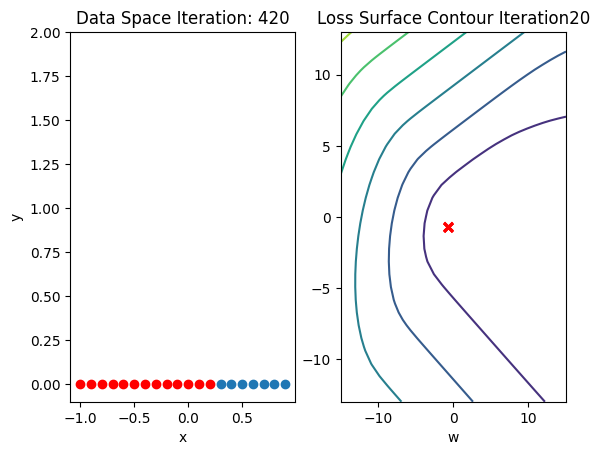

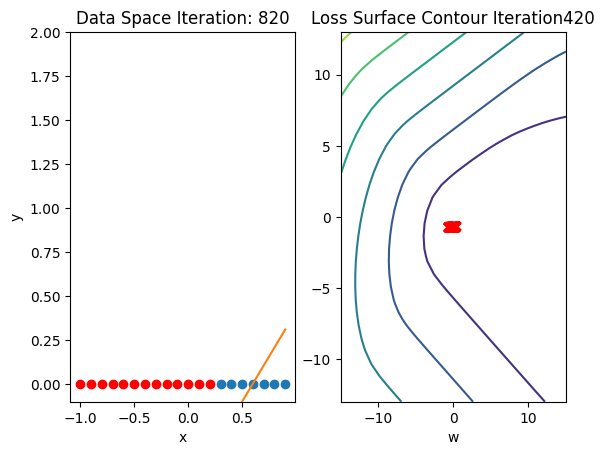

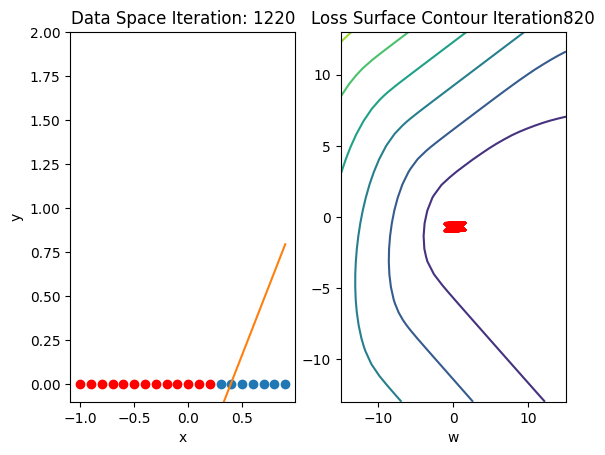

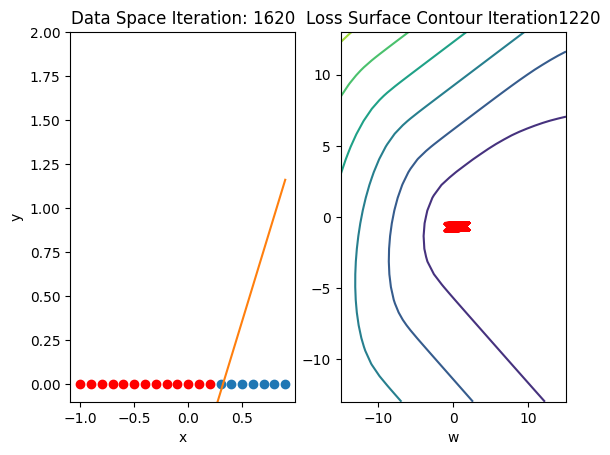

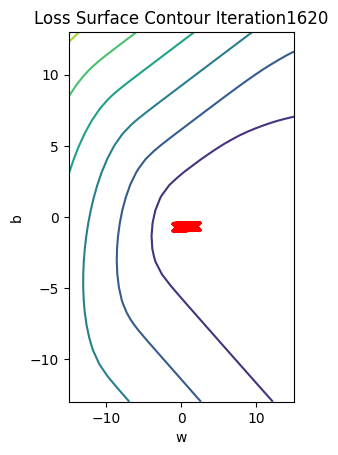

In [28]:
model = logistic_regression(1)
criterion = nn.BCELoss()
trainloader = DataLoader(dataset = data_set, batch_size = 1)
optimizer = torch.optim.SGD(model.parameters(), lr = .01)
epochs=100
loss_values = []

for epoch in range(epochs):
    for x, y in trainloader:
        yhat = model(x)
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        get_surface.set_para_loss(model, loss.tolist())
        loss_values.append(loss)
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

We can see the final values of the weight and bias. This weight and bias correspond to the orange line in the Data Space graph and the final spot of the X in the Loss Surface Contour graph.

In [29]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([2.3581]) b =  tensor(-0.6842)


Now we can get the accuracy of the training data

In [30]:
yhat = model(data_set.x)
yhat = torch.round(yhat)
correct = 0
for prediction, actual in zip(yhat, data_set.y):
    if (prediction == actual):
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


Finally, we plot the Cost vs Iteration graph, although it is erratic it is downward sloping.

Text(0, 0.5, 'Cost')

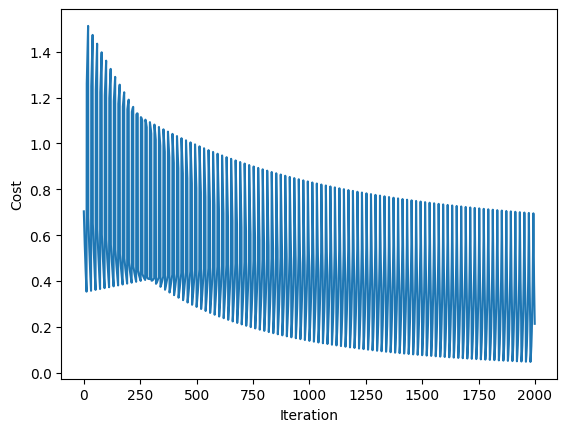

In [31]:
LOSS_BGD1=[]
for i in loss_values:
    LOSS_BGD1.append(i.item())


plt.plot(LOSS_BGD1)
plt.xlabel("Iteration")
plt.ylabel("Cost")